In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: good guesses for planets' mean periods

In [2]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

### define timestep dt, start/end times of integration

In [3]:
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt) # jaxttv class

### set observed transit times and errors (necessary to obtain model transit times)

In [4]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=True)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help

initial objective function: 5448.23 (53 data)

running optimization...
objective function: 50.21 (53 data)
# elapsed time (least square): 1.9 sec


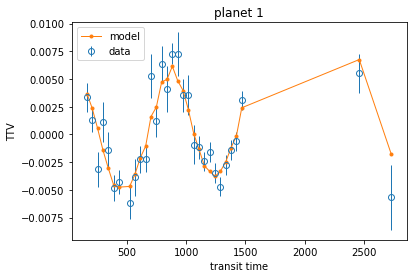

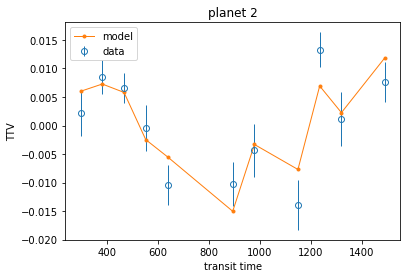

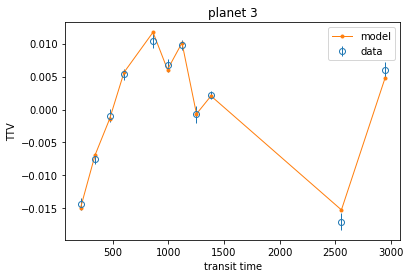

In [5]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)

### check precision of transit times

In [6]:
%%time
tc, tc_precise = jttv.check_timing_precision(params_best)

# fractional energy error (symplectic, dt=1.00e+00): 3.16e-09
# fractional energy error (Hermite4, dt=4.52e-02): -5.20e-12
# max difference in tc: 6.01e-06 days (0.52 sec)
CPU times: user 4.64 s, sys: 125 ms, total: 4.76 s
Wall time: 4.65 s


In [7]:
%%time
_, tc_precise_sym = jttv.check_timing_precision(params_best, symplectic=True)

# fractional energy error (symplectic, dt=1.00e+00): 3.16e-09
# fractional energy error (symplectic, dt=4.52e-02): 6.48e-12
# max difference in tc: 6.11e-06 days (0.53 sec)
CPU times: user 4.21 s, sys: 97.2 ms, total: 4.31 s
Wall time: 4.14 s


### check the distribution of residuals

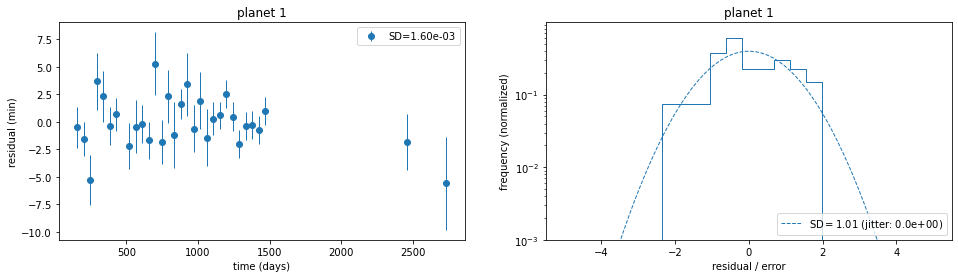

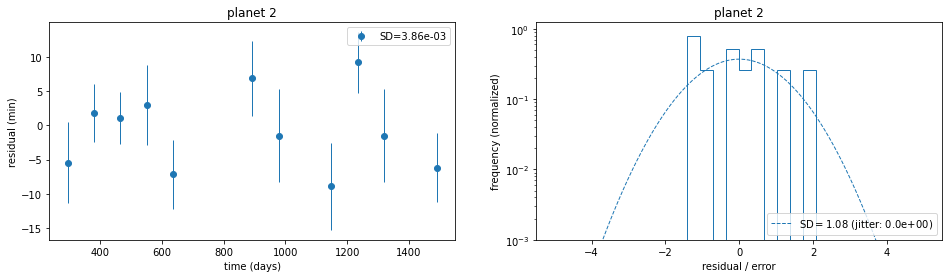

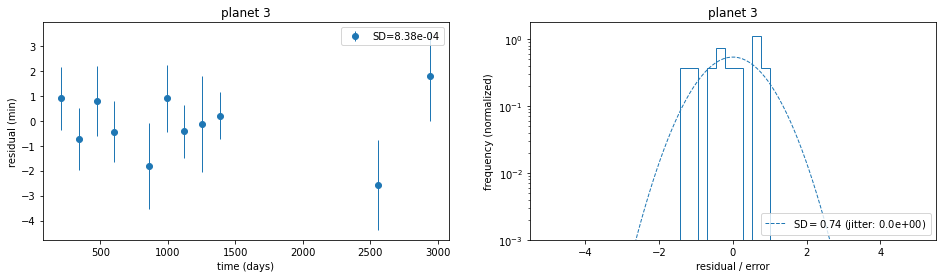

In [8]:
jttv.check_residuals(tc)

In [9]:
elements, masses = params_to_elements(params_best, jttv.nplanet)
pdic = pd.DataFrame(elements_to_pdic(elements, masses))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  2.571991   45.154003 -0.021177 -0.029450   0.0   -0.0  159.110553   
1  4.054968   85.314028  0.015834 -0.004341   0.0   -0.0  295.320951   
2  5.228739  130.183979  0.009119 -0.003446   0.0    0.0  212.023436   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.036274 -2.194223 -11.771055  0.000008 -0.583821 -0.811883  
1  0.016418 -0.267559 -11.315793  0.000012  0.964419 -0.264378  
2  0.009749 -0.361254 -11.061566  0.000016  0.911929 -0.344559  


In [15]:
from jax import grad, jit
func = lambda elements, masses: jnp.sum(jttv.get_ttvs(elements, masses)[0])
gfunc = jit(grad(func))
%timeit jttv.get_ttvs(elements, masses)

2.76 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit jac_best = gfunc(elements, masses)

19.8 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
tc_nodata, _ = jttv.get_ttvs_nodata(elements, masses, flatten=True, symplectic=True)

In [14]:
from jnkepler.jaxttv.utils import findidx_map

In [15]:
np.max(np.abs(tc_nodata[findidx_map(tc_nodata, tc)] - tc))*86400.

0.029326105141080916

In [31]:
tc_nodata

array([ 159.11120909,  204.26514293,  249.41861548,  294.57194028,
        339.72558693,  384.87934962,  430.03449247,  475.18935911,
        520.34511381,  565.50149675,  610.6582629 ,  655.81458703,
        700.97254159,  746.12873718,  791.28628597,  836.44179105,
        881.5982575 ,  926.75224333,  971.90662835, 1017.06025243,
       1062.21336721, 1107.36721261, 1152.52101454, 1197.67578747,
       1242.83060507, 1287.98636491, 1333.1425409 , 1378.29911559,
       1423.45545307, 1468.61326741, 1513.7692147 , 1558.92676174,
       1604.08242381, 1649.23879931, 1694.39280255, 1739.54753302,
       1784.70103562, 1829.85408522, 1875.00834412, 1920.16210382,
       1965.31669112, 2010.47187281, 2055.62765089, 2100.78353367,
       2145.94039262, 2191.09685648, 2236.25439307, 2281.41048247,
       2326.56809626, 2371.72350145, 2416.87986939, 2462.03401685,
       2507.18865557, 2552.34194856, 2597.49499742, 2642.64910327,
       2687.80261835, 2732.95714537, 2778.1124804 , 2823.26810

### initialize HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [10]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.3, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))
    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))
    lnode = numpyro.deterministic("lnode", ones*0)
    cosi = numpyro.deterministic("cosi", ones*0)
    
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = numpyro.deterministic("mass", jnp.exp(lnmass))

    elements = numpyro.deterministic("elements", jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T)
    masses = numpyro.deterministic("masses", jnp.hstack([1., mass]))

    tcmodel, ediff = jttv.get_ttvs(elements, masses)
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
        
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [11]:
pdic_init

{'period': DeviceArray([ 45.15400322,  85.31402842, 130.18397873], dtype=float64),
 'cosi': DeviceArray([0., 0., 0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.,  0.], dtype=float64),
 'tic': DeviceArray([159.11055344, 295.32095114, 212.02343566], dtype=float64),
 'ecc': DeviceArray([0.03627368, 0.01641781, 0.00974852], dtype=float64),
 'lnmass': DeviceArray([-11.77105535, -11.31579311, -11.06156579], dtype=float64),
 'mass': DeviceArray([7.72494892e-06, 1.21790522e-05, 1.57044603e-05], dtype=float64),
 'cosw': DeviceArray([-0.58382059,  0.96441913,  0.9119293 ], dtype=float64),
 'sinw': DeviceArray([-0.8118827 , -0.26437803, -0.34455853], dtype=float64)}

In [12]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)#, forward_mode_differentiation=True)

In [13]:
nw, ns, linm, tcjitter = 100, 100, True, None  # 2hr -> 40min
#nw, ns, linm, tcjitter = 500, 1000, True, None # 13.5hr (new) -> 5hr!

In [14]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [15]:
output = "kep51/dt%.1f_"%jttv.dt
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [16]:
output

'kep51/dt1.0_nw100_ns100_c2_'

In [17]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior) and 0:
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.46      0.23     -0.43     -0.81     -0.10      7.00      1.02
   cosw[1]      0.97      0.13      0.98      0.76      1.17      6.69      1.52
   cosw[2]      0.32      0.21      0.28      0.05      0.54      3.46      2.21
    ecc[0]      0.05      0.02      0.05      0.03      0.08      6.22      1.17
    ecc[1]      0.03      0.01      0.03      0.01      0.05      3.45      1.54
    ecc[2]      0.02      0.01      0.02      0.01      0.04      3.33      1.64
   mass[0]      0.00      0.00      0.00      0.00      0.00      4.86      1.18
   mass[1]      0.00      0.00      0.00      0.00      0.00      6.58      1.13
   mass[2]      0.00      0.00      0.00      0.00      0.00      7.21      1.24
 period[0]     45.15      0.00     45.15     45.15     45.15     12.04      1.02
 period[1]     85.31      0.00     85.31     85.31     85.32      5.18      1.51
 period[2]    130.18      0

In [46]:
samples = mcmc.get_samples()

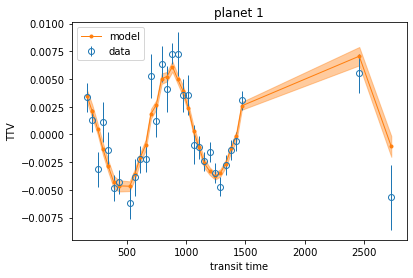

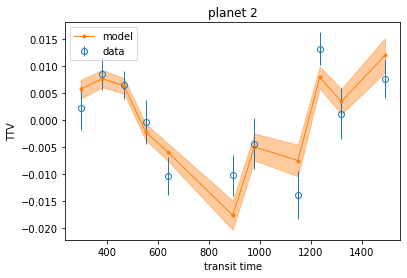

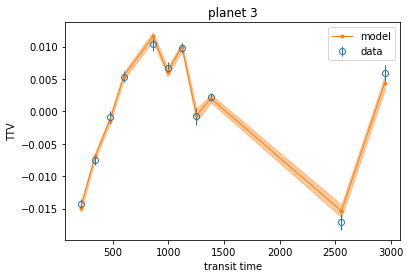

In [47]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel)#, save=output+"postm")

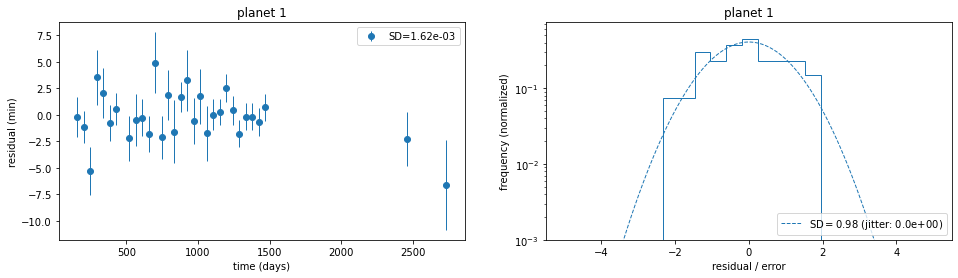

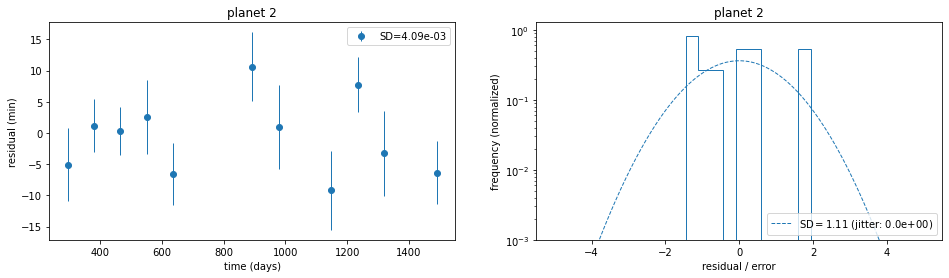

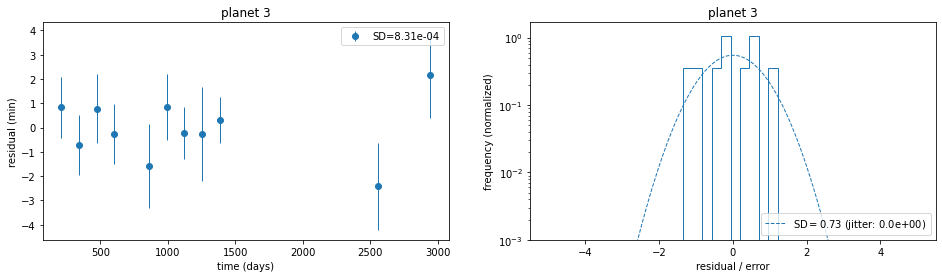

In [48]:
jttv.check_residuals(mmodel)

(array([ 4.,  7.,  6., 13.,  8., 17., 16., 18.,  3.,  8.]),
 array([-8.65112777, -8.62740762, -8.60368747, -8.57996732, -8.55624718,
        -8.53252703, -8.50880688, -8.48508673, -8.46136658, -8.43764643,
        -8.41392628]),
 <BarContainer object of 10 artists>)

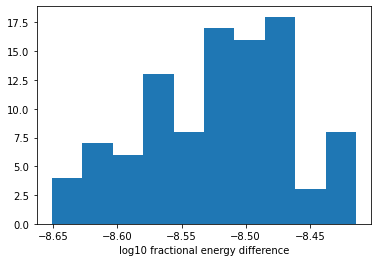

In [49]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [50]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

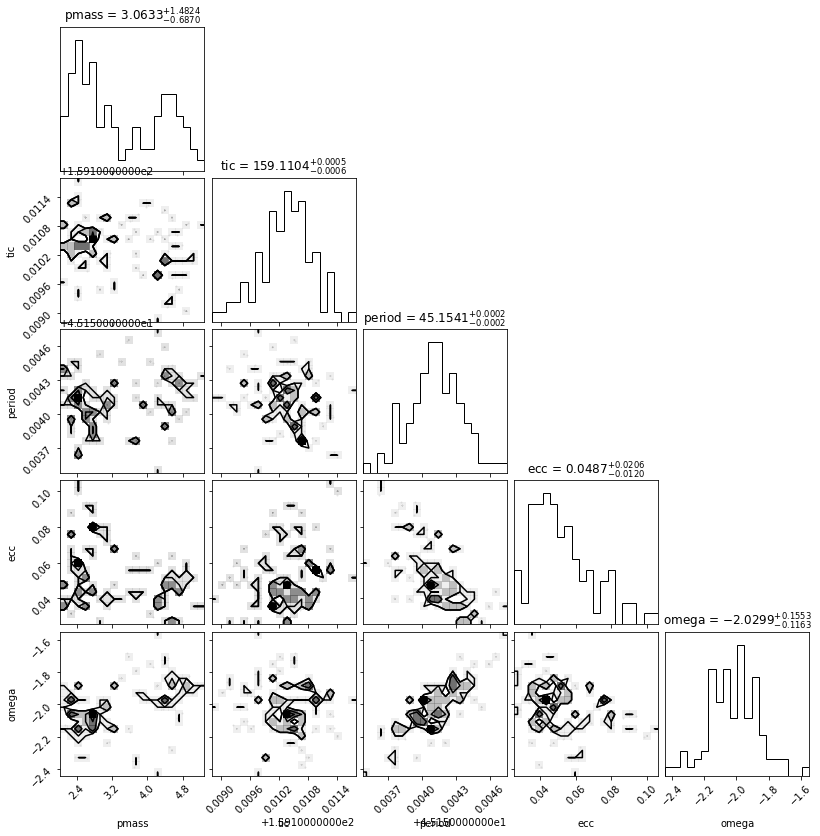

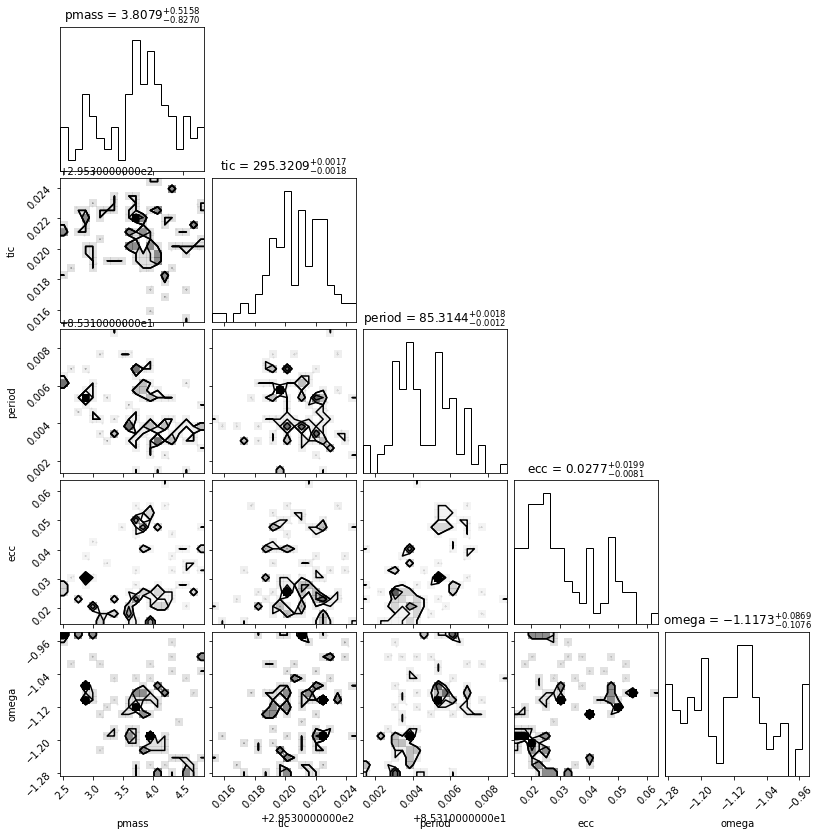

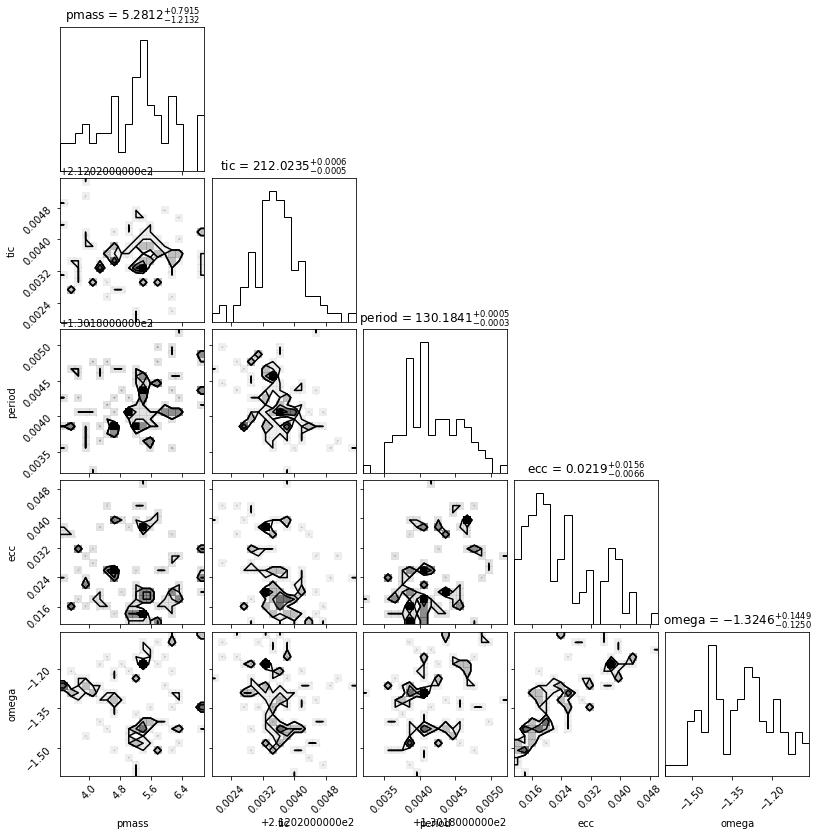

In [51]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    #plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");